<a href="https://colab.research.google.com/github/4may/SuperResolutionSurvey/blob/master/survey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Image Super-resolution: A Survey

超解像に関するサーベイ論文を読む。この論文は、2020/2月に発表された。

## Abstract

超解像は、画像処理の技術の一つであり、ディープラーニングの発展に伴って急速に成長している。

筆者は、超解像に関する技術を３つのグループに分けている。
* supervised SR
* unsupervised SR
* domain-specific SR

また、アルゴリズムの解説に加え、ベンチマークのためのデータセットやパフォーマンスの評価手法についても紹介する。

## Introduction

* Super Resolution(SR)とは、低解像度の画像から高解像度の画像を生成する技術を指す
* 現在の画像よりもより高解像度の画像を得るためには、画素数を増やす必要がある。画素数を増やすためには、本来存在しない画素によって画素同士の間を補完する必要がある。その補完パターンは何通りも考えられ、簡単に決定できるものではない。
* 手法は、様々ある。
  * prediction-based methods
  * edge-based methods
  * statistical methods
  * patch-based methods
  * sparse representation methods
  * **deep learning based methods**
* 一口にdeep learningに基づいた手法と言っても、そのアプローチの仕方は千差万別である。
  * ネットワークアーキテクチャ
  * 損失関数
  * 学習戦略などなど・・・

いかに、SRの俯瞰図を示す。

In [0]:
import cv2
import matplotlib.pyplot as plt

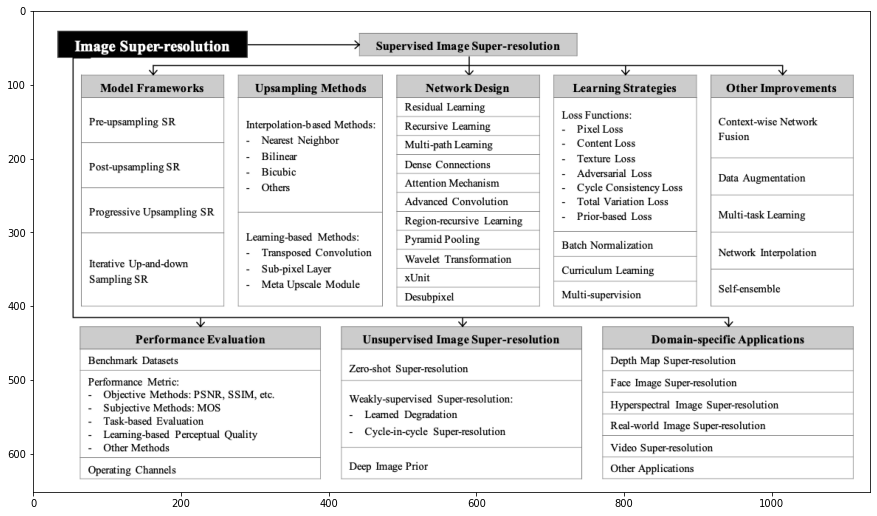

In [3]:
plt.figure(figsize=(15, 15))
img = cv2.imread("super_resolution_overview.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Problem Setting and Terminology

### 問題定義

超解像の最適化は、以下のように定義できる。

1. 入力画像の解像度を一度落とす。解像度を落とす方法としては、ダウンサンプリングがよく使われる。
2. 1の画像の解像度を入力画像の解像度に戻す
3. 入力画像と2の画像を比べて、可能な限りその誤差が小さくなるような学習パラメータを探す

### データセット

主なデータセットを以下に示す。

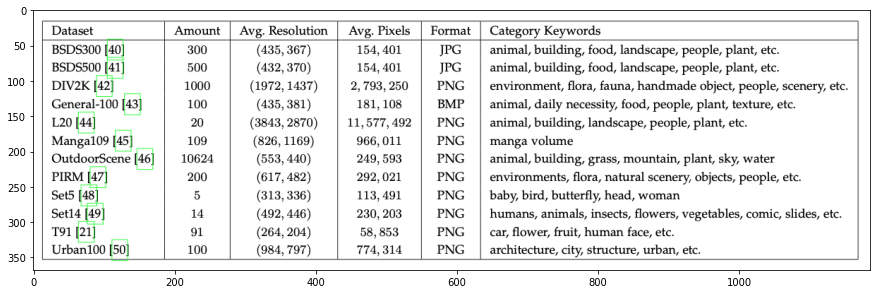

In [4]:
plt.figure(figsize=(15, 15))
img = cv2.imread("dataset.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### 画像の品質評価

画像の品質を評価する方法としては、主に二つのアプローチがある。

* 実際に人が目で見て判断する方法(いかに本物っぽく見えるか)
* 機械的に計算する方法

一般的に、前者は時間がかかってしまうため、後者の手法が主流である。しかし、数値上優れているからと言って、人が目で見た時も優れているとは限らない点には注意。

後者の方法は、さらに３つの手法に分けられる。

* full-reference methods (評価のために画像を使う方法)
* reduced-reference methods (画像全体ではなく、画像の特徴量を使う方法)
* no-reference methods (画像を使わない方法)

**Peak Signal to Noise Ratio(PSNR)**

PSNRは、画像変換の誤差を表す指標として最も一般的な指標である。

PSNRは、以下の式で表される。

$PSNR=10 * log_{10}(\frac{L^2}{\frac{1}{N}\sum_{i=1}^N{(I(i)-\hat{I}(i))^2}})$

* $L$ : 最大ピクセル値。8bit表記の画像であれば、255.
* $N$ : ピクセル数
* $I(i)$ : 入力画像$I$のi番目のピクセル値
* $\hat{I}(i)$ : 復元画像$\hat{I}$のi番目のピクセル値

PSNRの分母は、二つのピクセル値の間のMSEと考えることができる。PSNRでは１ピクセル毎の局所的な違いのみを考慮しているため、人が実際に見たときの結果と必ずしも一致しているとは限らない。

**Structural Similarity Index(SSIM)**

SSIMは、画像の構造を表現することを試みる評価指標である。SSIMは、PSNRに比べると、より人間の感覚に近い指標であり、PSNRと共に広く使われている。

SSIMは以下の式で表される。

$SSIM(I, \hat{I}) = [C_l(I, \hat{I})]^α[C_c(I, \hat{I})]^β[C_s(I, \hat{I})]^γ$

ただし、luminance, contrast, structure comparison functionはそれぞれ以下の式で表せる。

$C_l(I, \hat{I}) = \frac{2μ_{I}μ_{\hat{I}}+C_1}{μ_{I}^2μ_{\hat{I}}^2+C_1}$

$C_c(I, \hat{I}) = \frac{2\sigma_{I}\sigma_{\hat{I}}+C_2}{\sigma_{I}^2\sigma_{\hat{I}}^2+C_2}$

$C_s(I, \hat{I}) = \frac{\sigma_{I\hat{I}}+C_3}{\sigma_{I}\sigma_{\hat{I}}+C_3}$

* $μ_I = \frac{1}{N}\sum_{i=1}^N{I(i)}$ ※$I$の平均ピクセル値
* $\sigma_{I} = (\frac{1}{N-1}\sum_{i=1}^N{(I(i)-μ_I)}^2)^{\frac{1}{2}}$ ※$I$のピクセル値の標準偏差
* $α, β, γ$ : 定数。


**Mean Opinion Score(MOS)**

ある画像に対して、1(bad)~5(good)までの５段階で人間が評価をつける。最終的な評価は、各評点の平均をとって計算する。

正確さという意味では、単純にして最強の評価方法。

**Learning based Perceptual Quality**

手作業によるばらつきを無くして、より正確に知覚的な評価を行うための手法。ただ、「知覚的な質」の定義が曖昧なのは、難点である。例えば、よりリアルな画像が欲しいのか、それとも入力の画像と近い画像が欲しいのか。

**Task based Evaluation**

入力画像と復元画像に対して、別の画像処理問題を試してみるのも一つの手だ。別の画像処理問題とは、例えば物体認識や顔認識、顔のパーツの配置や分解などが挙げられる。

### 色空間

Super Resolutionでは、RGB空間に加えてYCbCr空間を使用することも多い。

**YCbCr色空間**

画像は３つの尺度で表現される.

* luminance (輝度)
* blue-difference　chroma (色差信号)
* red-difference chroma (色差信号)

YCbCrはRGBに比べて、より色の「明るさ」に着目した色空間である。これは、人間の目は明るさの変化には敏感だが、色の変化には鈍感である、という人の性質に依拠している。m

## Supervised Super Resolution

### Supervised Super Resolutionのフレームワーク

Supervised Super Resolutionのアプローチ方法としては、大きく4種類ある。どのタイミングでupsamplingするかが分かれ目となっている。

1. Pre-upsampling SR
2. Post-upsampling SR
3. Progressive upsampling SR
4. Iterative up-and-down Sampling SR

**1. Pre-upsampling SR**

* ネットワークの最初にupsamplingする手法
* 最も複雑で、かつ肝となるupsamplingを最初に行うため、学習の複雑さは低い
* 4つのアプローチの中では、最もよく使われるアプローチ
* upsamplingを最初に行うことで、副作用もある
  * ノイズの強調
  * 画像ぼけ
* 高解像度(高次元)の画像では、他のアプローチよりも計算コストが高くなるケースもある

**2. Post-upsampling SR**

* ネットワークの最後にupsamplingする手法
* このアプローチの狙いは、解像度の低い(低次元の)画像を使うことで、計算コストを下げること。
* Pre-upsamplingと同様によく使われるアプローチ

**3. Progressive upsampling SR**

* 一度にまとめてupsamplingするのではなく、何回かに分けてupsamplingする手法。
  * 畳み込み -> upsampling -> 畳み込み -> upsamplingのようなイメージ
* 一度にまとめてupsamplingすると学習の複雑さが急激に上がってしまうという問題点があった

**4. Iterative up-and-down Sampling SR**

* upsamplingとdownsamplingを何度か繰り返す手法。このようにup downを繰り返す仕組みをback-projectionと呼ぶ。
  * HRとLRの相互の関係性を捉えようとする
  * 復元の際の「誤差」を学ぶ
* 他の手法に比べて、より高品質な画像が得られる
* 一方で、動作原理については解明の余地有り

以下、各手法を図で示す。

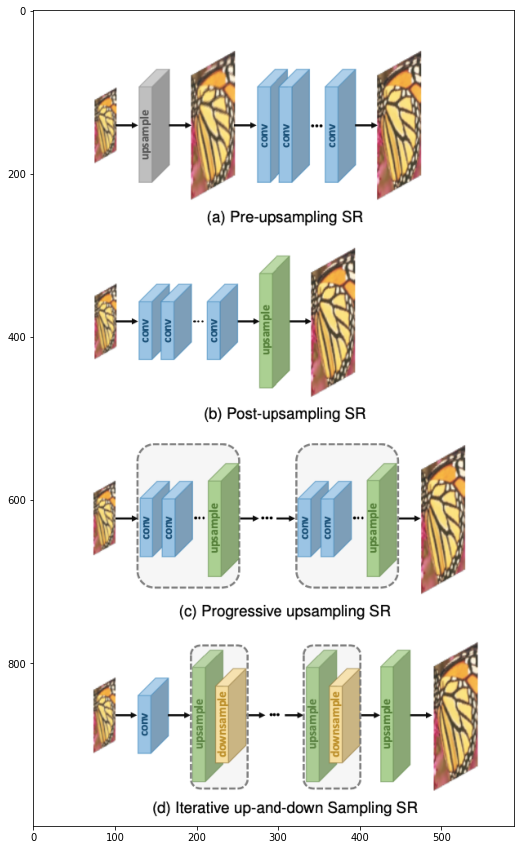

In [5]:
plt.figure(figsize=(15, 15))
img = cv2.imread('upsampling.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#### Upsampling手法

まず、大きく二つある. 最近のトレンドは後者。

* Interpolation-based upsampling
* Learning-based upsampling

**Interpolation-based upsampling**

３つの手法がある。

* Nearest-neighbor
  * 各座標毎に最も近いピクセルの値をそのまま使う
  * ３つの手法の中で一番高速だが、質が低い
* Bilinear
  * 一方の軸で線型補間をした後に、もう一方の軸で線型補間する。
  * 補間対象となる座標周辺2x2のピクセル値を使う
  * Nearest-neighborと同じ位の速度でより高品質な画像が得られる
* Bicubic
  * 補間対象となる座標周辺4x4のピクセル値を使う。単純に、bilinearの4倍多いピクセル値を使う。
  * 画像はより滑らかになる。また、補間速度は遅くなる。

補間に基づくupsamplingには副作用がある。

* ノイズ強調
* 計算的複雑さ
* 画像ぼけ

そのため、最近は後述するLearning-based upsamplingが使われることが多い。特に、Post-upsampling SRの最後のlayerとして使われる。

**Learning-based upsampling**

interpolationに基づくupsamplingの欠点を克服するため、二つの仕組みを導入する。

* transposed convolution layer
  * zero-paddingした後にconvolutionすることで、入力画像のピクセル間の繋がりを損ねないまま画像の解像度を大きくすることができる。
* sub-pixel layer
  * R,G,B,RGBという４つの色パターンに対するconvolutionを行い、各結果ごとにスカラーを計算する。すると、４つのスカラーが得られるので、その４つを組み合わせてupsampling imageを作成する。
  * よりリアルな画像が得られる。

ただし、これらの手法にも課題はある

* 格子状の模様が浮かび上がることがある。(画像がギザギザする)
  * 原因は二つ
    * filter overlap. kernelやstrideサイズによってはconvolutionに使われるピクセルの数が、場所によって異なる可能性がある。
    * kernel初期化(sub-pixel layerの場合)
      * 解決策として、[ICNRという手法](https://amalog.hateblo.jp/entry/icnr-pytorch)がある

### ネットワークデザイン

論文では８種類にまとめている。

1. residual learning
2. recursive learning
3. channel attention
4. dense connections
5. local multi-path learning
6. scale-specific multi-path learning
7. group convolution
8. pyramid pooling

最初に図で示す。

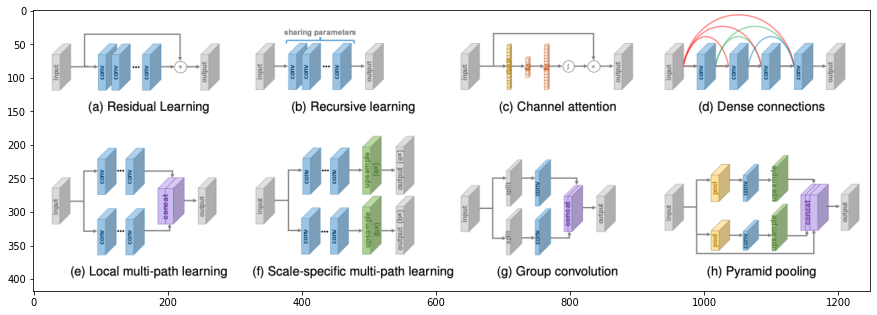

In [6]:
plt.figure(figsize=(15, 15))
img = cv2.imread("network_design.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#### Residual Learning

ResNetでも使われていた仕組み。

**Global Residual Learning**

* 入力画像とターゲット画像のredisual(差分)だけを学習する方法
* residualは、多くの座標で0に近い値となるため、計算を高速に行える
* SRでもよく使われている

**Local Residual Learning**

* ResNetで使われていた仕組みと一緒
* SRでもよく使われている

どちらの手法も「ショートカット」な繋がりを作って要素和を計算することは共通している。前者と後者の手法の実装上の違いを述べる。前者は、入力画像と出力画像を直接結ぶ。したがって、ショートカットは一本のみ。一方、後者はネットワーク内部の複数のlayerがショートカットで繋がるため、複数のショートカットが使われる。

上の図のresidual learningは、入力画像と出力画像が直接つながっているため、前者に該当する。

#### Recursive Learninig

* 層の数をできるだけ増やさないようにして、より高いレベルの特徴量を学習するための手法
* 同じモジュールを繰り返し使う
* 計算コストがでかい
* 勾配消失/勾配発散のリスクあり
* -> residual learningやmulti-supervisionと併用

#### Multi-path Learning

3種類ある

**Global Multi-path Learning**

* 複数の学習を並列して行う
* パス毎に役割が異なる
  * 特徴量を抽出するパス。さらに、低次元と高次元でパスを分けることもある
  * 他のパスの信号からHR画像を生成するパス
* ポイントは、各パスが情報交換しながら学習をするということ

**Local Multi-path Learning**

* 複数の学習を並列して行う
* 各パスの結果は最後にマージされる。学習途中では情報交換しないのがglobalとの違い。

**Scale-specific Multi-path Learning**

* 複数のスケールを扱いたい時もある
* スケール毎にパスを分け、各パス毎に画像を出力する

#### Dense Connections

* ある層の出力を残り全ての層の入力とする. layer数をlとすると、$l*\frac{(l-1)}{2}$本の接続が存在することになる
* メリットは以下
  * 勾配消失、勾配爆発を防げる
  * 特徴量の再利用が可能
  * モデルサイズを小さくできる

#### Attention Mechanism

**Channel Attention**

* Attention layerとFC layerで構成される機構。8種の手法の中では唯一convolution layerが使われない。
* 異なるチャンネル間の相互依存関係を考慮するモデル
* 最初のAttention layerにおいて、各チャンネル毎にGlobal Average Poolingを使ってスカラーを計算する
* 最近の中では高性能な[RCAN](https://arxiv.org/pdf/1807.02758.pdf)は、このChannel Attentionを使っている。

**Non-local Attention**

* 遠く離れているピクセル間の関係性を考慮するための仕組み
* パッチ生成の際には離れているピクセルの情報も重要になる

#### Advanced Convolution

**Dilated Convolution**

* dilated convolutionを使うことで、あるピクセルから離れたピクセルの値を反映することができる。
* dilated convolutionでは、スパースなカーネルを使う
* カーネルのスパースさは、dilation rateによって決まる、言い換えれば、dilation rateによって、どれだけ遠くのピクセル情報を使うかが決定する。dilation rateが高ければ高いほど遠くのピクセル情報を使うことになる。
  * dilation rate=1は普通のカーネル。dilation rate=2はピクセルとピクセルの間に１つ０が挿入される。つまり、対象のピクセルに対して、二つ先のピクセルの情報を加味する

**Group Convolution**

* ほぼ精度を落とさずに、パラメータ数を減らすことができる。
* サイズ(W, H, L)の入力データをLayer方向にG個へ分割してサイズ(W,H,L/G)のデータをG個える。そして、G個のデータ毎に畳み込みを行う。最後に各データ毎の結果をマージしてサイズ(W,H,L)のデータを得る。

**Depthwise Separable Convolution**

* パラメータ数を減らせる
* 各チャンネル毎に単一のフィルタを使うようにしたconvolution
  * 通常のconvolutionでは、各チャンネル毎に同じ数$C_{out}$枚だけのフィルタが使われる。
  * Depthwise convolutionを使うことで、パラメータ数を$\frac{1}{C_{out}}$倍することができる。
